In [ ]:
import jax
import jax.numpy as jnp

# Assuming these are the locations of your modules
from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a, _calculate_gvs_vectorized
from chewc.phenotype import set_pheno
import numpy as np

# JAX random key setup
key = jax.random.PRNGKey(42)
key, pop_key, trait_key = jax.random.split(key, 3)

# 1. Generate the founder population and its genetic map together.
founder_pop, genetic_map = msprime_pop(
    key=pop_key, n_ind=6, n_loci_per_chr=1000, n_chr=1, ploidy=2
)

# 2. Use the founder population and its map to configure the simulation's rules.
SP = SimParam.from_founder_pop(
    founder_pop=founder_pop,
    gen_map=genetic_map,
    sexes="no"
)

# 3. Add two additive traits with a negative genetic correlation.
# Define trait means, variances, and the correlation matrix
trait_means = jnp.array([0.0, 0.0])
trait_vars = jnp.array([1.0, 1.0])
neg_cor_matrix = jnp.array([[1.0, 0.6],
                           [0.6, 1.0]])

# Call the function to add the traits
SP = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=SP,
    n_qtl_per_chr=500,
    mean=trait_means,
    var=trait_vars,
    cor_a=neg_cor_matrix
)


# Split the JAX key for two separate phenotyping operations
key = jax.random.PRNGKey(42) # A fresh key for this block
key, h2_key, varE_key = jax.random.split(key, 3)

# --- Example 1: Phenotyping with Heritability (h2) ---

# Define the narrow-sense heritability for each trait
heritabilities = jnp.array([0.3, 0.6])

# Call the JIT-compiled set_pheno function using the h2 argument
pop_with_h2 = set_pheno(
    key=h2_key,
    pop=founder_pop,
    traits=SP.traits,
    ploidy=SP.ploidy,
    h2=heritabilities
)

# --- Verification (Optional) ---
# Calculate genetic values for the new traits in the founder population
bvs,gvs = _calculate_gvs_vectorized(founder_pop, SP.traits, SP.ploidy)

print(np.mean(gvs[:,1]))
print(np.var(gvs[:,1]))


print(np.mean(pop_with_h2.gv[:,1]))
print(np.var(pop_with_h2.gv[:,1]))


6.357829e-07
1.0000006
6.357829e-07
1.0000006


In [ ]:
import jax
import jax.numpy as jnp

# Assuming these are the locations of your modules
from chewc.population import msprime_pop, Population
from chewc.sp import SimParam
from chewc.trait import add_trait_a, _calculate_gvs_vectorized, TraitCollection
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
import numpy as np
from functools import partial
from jaxtyping import Array, Float

# JAX random key setup
key = jax.random.PRNGKey(42)
key, pop_key, trait_key = jax.random.split(key, 3)

# 1. Generate the founder population and its genetic map together.
founder_pop, genetic_map = msprime_pop(
    key=pop_key, n_ind=6, n_loci_per_chr=10, n_chr=2, ploidy=2
)

# 2. Use the founder population and its map to configure the simulation's rules.
SP = SimParam.from_founder_pop(
    founder_pop=founder_pop,
    gen_map=genetic_map,
    sexes="no"
)

# 3. Add two additive traits with a negative genetic correlation.
# Define trait means, variances, and the correlation matrix
trait_means = jnp.array([0.0, 0.0])
trait_vars = jnp.array([1.0, 1.0])
neg_cor_matrix = jnp.array([[1.0, 0.6],
                           [0.6, 1.0]])

# Call the function to add the traits
SP = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=SP,
    n_qtl_per_chr=10,
    mean=trait_means,
    var=trait_vars,
    cor_a=neg_cor_matrix
)


# Split the JAX key for two separate phenotyping operations
key = jax.random.PRNGKey(42) # A fresh key for this block
key, h2_key, varE_key = jax.random.split(key, 3)

# --- Example 1: Phenotyping with Heritability (h2) ---

# Define the narrow-sense heritability for each trait
heritabilities = jnp.array([0.3, 0.6])

# Call the JIT-compiled set_pheno function using the h2 argument
pop_with_h2 = set_pheno(
    key=h2_key,
    pop=founder_pop,
    traits=SP.traits,
    ploidy=SP.ploidy,
    h2=heritabilities
)

# --- Verification (Optional) ---
# Calculate genetic values for the new traits in the founder population
bvs,gvs = _calculate_gvs_vectorized(founder_pop, SP.traits, SP.ploidy)

print("--- Founder Population Verification ---")
print(f"Mean GV (Trait 2, pre-pheno): {np.mean(gvs[:,1]):.4f}")
print(f"Var GV (Trait 2, pre-pheno):  {np.var(gvs[:,1]):.4f}")


print(f"Mean GV (Trait 2, post-pheno): {np.mean(pop_with_h2.gv[:,1]):.4f}")
print(f"Var GV (Trait 2, post-pheno):  {np.var(pop_with_h2.gv[:,1]):.4f}")


# ===================================================================
# --- EXTENSION: Pick 3 random pairs and make 20 offspring per cross ---
# ===================================================================

print("\n--- Starting Breeding Extension ---")

# A new key for this entire breeding operation
key, breeding_key = jax.random.split(key)

# 1. Define breeding parameters
n_pairs = 3
n_offspring_per_pair = 100
n_parents_to_select = n_pairs * 2
total_offspring = n_pairs * n_offspring_per_pair

# 2. Select 6 unique parents without replacement from the founder population
# We use their internal IDs (iids), which are 0-99 for the founder pop.
select_key, cross_key, pheno_key = jax.random.split(breeding_key, 3)
parent_indices = jax.random.choice(
    select_key,
    pop_with_h2.nInd, # Choose from all individuals (0 to 99)
    shape=(n_parents_to_select,),
    replace=False
)
print(f"Selected parent indices (iids): {parent_indices}")

# 3. Form the cross plan
# Reshape the 6 parent indices into 3 pairs of (mother, father)
# The `make_cross` function is vectorized, so we create a plan where each
# row represents one desired offspring.
pairs = parent_indices.reshape((n_pairs, 2))
print(f"Formed pairs (mother iid, father iid): \n{pairs}")

# Repeat each pair `n_offspring_per_pair` times to create the full cross plan
# This will result in a (60, 2) array.
cross_plan = jnp.repeat(pairs, repeats=n_offspring_per_pair, axis=0)
print(f"Shape of the final cross plan: {cross_plan.shape}")

# 4. Execute the crosses to create progeny
# The `make_cross` function generates the genotypes and pedigree info.
# Note: The returned population will have placeholder values for bv, gv, pheno.
progeny_pop_no_values = make_cross(
    key=cross_key,
    pop=pop_with_h2,
    cross_plan=cross_plan,
    sp=SP,
    next_id_start=SP.last_id # Start new IDs after the founders (e.g., at 100)
)

print(f"\nCreated a new progeny population (without phenotypes yet):")
print(progeny_pop_no_values)
print(f"Progeny IDs range from {progeny_pop_no_values.id[0]} to {progeny_pop_no_values.id[-1]}")
print(f"First offspring's mother ID: {progeny_pop_no_values.mother[0]}, father ID: {progeny_pop_no_values.father[0]}")

# 5. Calculate genetic values and phenotypes for the new progeny
# We use the same heritabilities as the founder generation.
final_progeny_pop = set_pheno(
    key=pheno_key,
    pop=progeny_pop_no_values,
    traits=SP.traits,
    ploidy=SP.ploidy,
    h2=heritabilities
)

print(f"\nFinal progeny population (with phenotypes calculated):")
print(final_progeny_pop)

# 6. Verification
# Check the mean and variance of the genetic values for the second trait in the new generation.
# Due to random mating and Mendelian sampling, these values should be similar but not
# identical to the parent generation.
progeny_gv_mean_t2 = jnp.mean(final_progeny_pop.gv[:, 1])
progeny_gv_var_t2 = jnp.var(final_progeny_pop.gv[:, 1])

print(f"\nVerification of progeny population (Trait 2):")
print(f"Mean Genetic Value: {progeny_gv_mean_t2:.4f}")
print(f"Variance of Genetic Value: {progeny_gv_var_t2:.4f}")

--- Founder Population Verification ---
Mean GV (Trait 2, pre-pheno): -0.0000
Var GV (Trait 2, pre-pheno):  1.0000
Mean GV (Trait 2, post-pheno): -0.0000
Var GV (Trait 2, post-pheno):  1.0000

--- Starting Breeding Extension ---
Selected parent indices (iids): [3 0 1 4 5 2]
Formed pairs (mother iid, father iid): 
[[3 0]
 [1 4]
 [5 2]]
Shape of the final cross plan: (300, 2)

Created a new progeny population (without phenotypes yet):
Population(nInd=300, nTraits=2, has_ebv=No)
Progeny IDs range from 6 to 305
First offspring's mother ID: 3, father ID: 0

Final progeny population (with phenotypes calculated):
Population(nInd=300, nTraits=2, has_ebv=No)

Verification of progeny population (Trait 2):
Mean Genetic Value: 0.0109
Variance of Genetic Value: 5.8896



--- Performing PCA and Visualizing Results ---
Shape of combined dosage matrix for PCA: (306, 20)
Explained variance by PC1: 22.04%
Explained variance by PC2: 16.15%


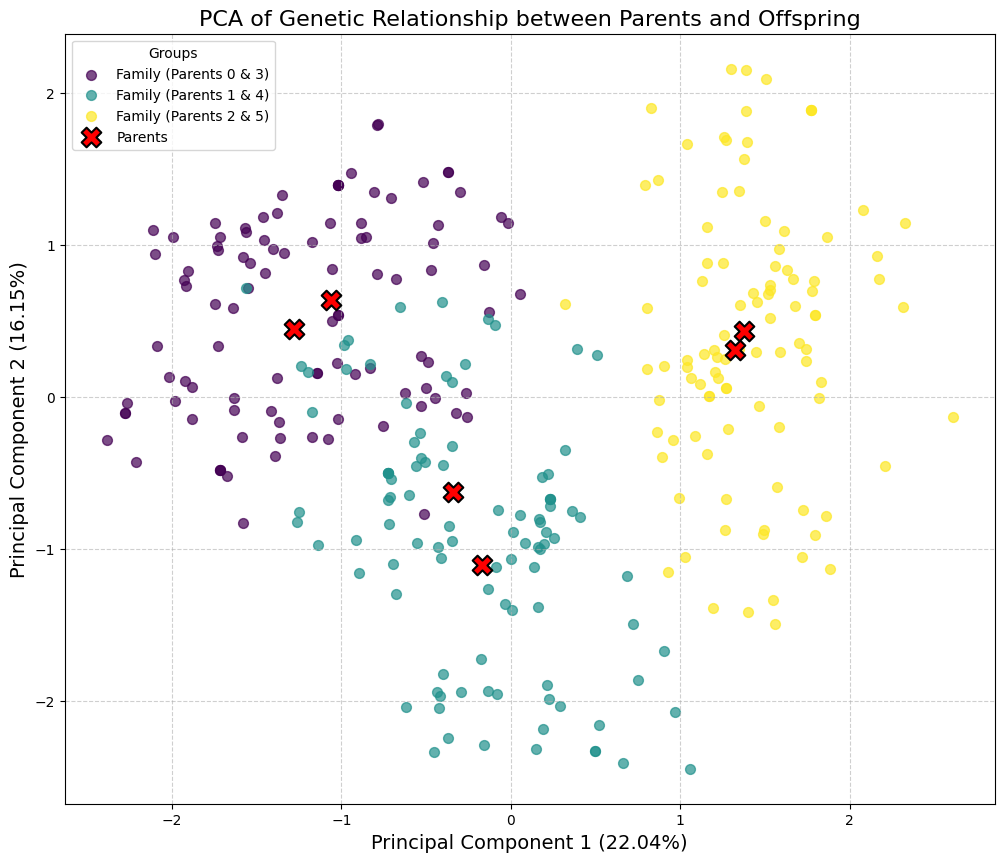

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np # Using numpy for some data manipulation for plotting

# ===================================================================
# --- PCA Visualization of Offspring and Parents ---
# ===================================================================

print("\n--- Performing PCA and Visualizing Results ---")

# 1. Prepare the data for PCA
# Get the dosage matrix for the parents from the original population
parent_dosage = pop_with_h2.dosage[parent_indices]

# Get the dosage matrix for all the offspring
offspring_dosage = final_progeny_pop.dosage

# Combine them into a single matrix. Parents will be the first 6 rows.
combined_dosage = jnp.vstack([parent_dosage, offspring_dosage])
print(f"Shape of combined dosage matrix for PCA: {combined_dosage.shape}")

# 2. Perform PCA
# We want to find the first 2 principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(combined_dosage)

# Explained variance helps understand how much information each PC captures
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")

# 3. Separate the results for plotting
pc_parents = principal_components[:n_parents_to_select]
pc_offspring = principal_components[n_parents_to_select:]

# 4. Create family labels for color-coding the offspring
# We can create a unique ID for each family based on the sorted parent IDs
offspring_mothers = np.array(final_progeny_pop.mother)
offspring_fathers = np.array(final_progeny_pop.father)

# Create a unique, sorted tuple for each family pair to handle (A,B) vs (B,A)
family_pairs = [tuple(sorted(pair)) for pair in zip(offspring_mothers, offspring_fathers)]
unique_families = sorted(list(set(family_pairs)))

# Create a color map for the families
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_families)))
family_color_map = {family: color for family, color in zip(unique_families, colors)}

# Assign a color to each offspring
offspring_colors = [family_color_map[family] for family in family_pairs]


# 5. Generate the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the offspring, color-coded by family
# We plot each family separately to create a clean legend
for i, family in enumerate(unique_families):
    # Find which offspring belong to this family
    family_mask = [fp == family for fp in family_pairs]
    ax.scatter(
        pc_offspring[family_mask, 0],
        pc_offspring[family_mask, 1],
        color=colors[i],
        label=f'Family (Parents {family[0]} & {family[1]})',
        alpha=0.7,
        s=50
    )

# Plot the parents with special markers
ax.scatter(
    pc_parents[:, 0],
    pc_parents[:, 1],
    marker='X',
    color='red',
    s=200,
    edgecolor='black',
    linewidth=1.5,
    label='Parents',
    zorder=10 # Ensure parents are plotted on top
)

# Add labels and title
ax.set_xlabel(f'Principal Component 1 ({explained_variance[0]:.2%})', fontsize=14)
ax.set_ylabel(f'Principal Component 2 ({explained_variance[1]:.2%})', fontsize=14)
ax.set_title('PCA of Genetic Relationship between Parents and Offspring', fontsize=16)
ax.legend(title="Groups")
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()


--- Creating Heatmap of Genotype Correlations ---
Shape of the resulting correlation matrix: (306, 306)
Top-left 5x5 corner of the matrix (parent-parent correlations):
[[1.     0.4415 0.3224 0.4223 0.425 ]
 [0.4415 1.     0.6506 0.606  0.2919]
 [0.3224 0.6506 1.     0.2796 0.3001]
 [0.4223 0.606  0.2796 1.     0.4013]
 [0.425  0.2919 0.3001 0.4013 1.    ]]


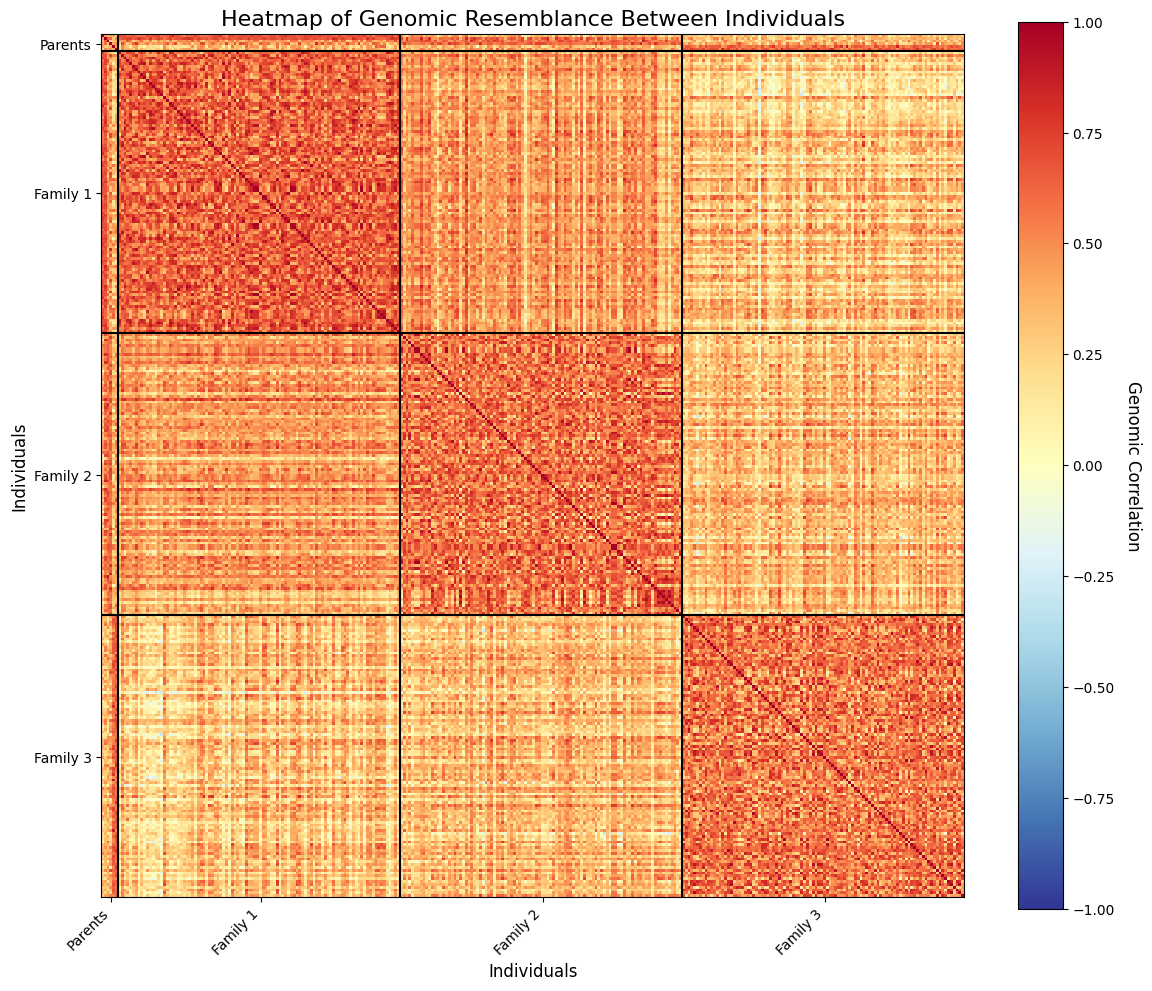

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================================
# --- Heatmap of Genotype Correlations (Genomic Relationship Matrix) ---
# ===================================================================

print("\n--- Creating Heatmap of Genotype Correlations ---")

# 1. Calculate the correlation matrix between individuals
# The `combined_dosage` matrix is already in the shape (n_individuals, n_loci).
# np.corrcoef calculates the correlation between rows, which is exactly what we want:
# an (n_individuals, n_individuals) matrix.
# Note: This differs from the R example where a transpose was needed.
# np.corrcoef treats rows as variables, whereas R's cor() treats columns as variables.
ind_correlation_matrix = np.corrcoef(combined_dosage)

print(f"Shape of the resulting correlation matrix: {ind_correlation_matrix.shape}")
print("Top-left 5x5 corner of the matrix (parent-parent correlations):")
print(np.round(ind_correlation_matrix[:5, :5], 4))


# 2. Prepare for plotting: Define group boundaries and labels
# We have one group of parents and three family groups.
group_sizes = [n_parents_to_select] + [n_offspring_per_pair] * n_pairs
group_labels = ['Parents'] + [f'Family {i+1}' for i in range(n_pairs)]

# Calculate the positions for the dividing lines (at the end of each group)
# The -0.5 is to place the line neatly between the pixels of the heatmap.
boundaries = np.cumsum(group_sizes)[:-1] - 0.5

# Calculate the positions for the labels (in the middle of each group)
tick_positions = np.cumsum(group_sizes) - np.array(group_sizes) / 2


# 3. Generate the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Use imshow to create the heatmap
# We use the 'RdYlBu_r' colormap which is a reversed Red-Yellow-Blue palette.
# Red = high positive correlation (high relatedness)
# Blue = high negative correlation (unrelated)
# Yellow = zero correlation
im = ax.imshow(ind_correlation_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1,
               interpolation='nearest', origin='upper')

# Add a colorbar to show the correlation scale
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Genomic Correlation", rotation=270, labelpad=20, fontsize=12)

# Add the dividing lines between groups
for pos in boundaries:
    ax.axhline(pos, color='black', linewidth=1.5)
    ax.axvline(pos, color='black', linewidth=1.5)

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(group_labels, rotation=45, ha="right")
ax.set_yticks(tick_positions)
ax.set_yticklabels(group_labels)

# Add title and labels
ax.set_title("Heatmap of Genomic Resemblance Between Individuals", fontsize=16)
ax.set_xlabel("Individuals", fontsize=12)
ax.set_ylabel("Individuals", fontsize=12)

plt.tight_layout()
plt.show()